The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# O *Dataset* de Detecção de Objetos
Não existem pequenos conjuntos de dados, como MNIST ou Fashion-MNIST, no campo de detecção de objetos. Para testar os modelos rapidamente, vamos montar um pequeno conjunto de dados. Primeiro, geramos 1000 imagens de banana de diferentes ângulos e tamanhos usando bananas grátis de nosso escritório. Em seguida, coletamos uma série de imagens de fundo e colocamos uma imagem de banana em uma posição aleatória em cada imagem.


## Baixando Dataset

O conjunto de dados de detecção de banana com todas as imagens e arquivos de rótulo csv pode ser
baixado diretamente da Internet.


In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip',
                           '5de26c8fce5ccdea9f91267273464dc968d20d72')

## Lendo o Dataset

Vamos ler o conjunto de dados de detecção de objetos na função `read_data_bananas`. O conjunto de dados inclui um arquivo csv para rótulos de classe de destino e coordenadas de caixa delimitadora de verdade fundamental no formato `corner`.
Definimos `BananasDataset` para criar a instância do `Dataset` e finalmente definimos a função `load_data_bananas` para retornar os carregadores de dados.
Não há necessidade de ler o conjunto de dados de teste em ordem aleatória.


In [2]:
#@save
def read_data_bananas(is_train=True):
    """Read the bananas dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                                    else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Since all images have same object class i.e. category '0',
        # the `label` column corresponds to the only object i.e. banana
        # The target is as follows : (`label`, `xmin`, `ymin`, `xmax`, `ymax`)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256


#@save
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)


#@save
def load_data_bananas(batch_size):
    """Load the bananas dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return (train_iter, val_iter)

Abaixo, lemos um minibatch e imprimimos o formato da imagem e do *label*. A forma da imagem é a mesma da experiência anterior (tamanho do lote, número de canais, altura, largura). O formato do rótulo é (tamanho do lote, $m$, 5), onde $m$ é igual ao número máximo de caixas delimitadoras contidas em uma única imagem no conjunto de dados. Embora o cálculo do minibatch seja muito eficiente, ele exige que cada imagem contenha o mesmo número de caixas delimitadoras para que possam ser colocadas no mesmo lote. Como cada imagem pode ter um número diferente de caixas delimitadoras, podemos adicionar caixas delimitadoras ilegais às imagens que possuem menos de $m$ caixas delimitadoras até que cada imagem contenha $m$ caixas delimitadoras. Assim, podemos ler um minibatch de imagens a cada vez. O rótulo de cada caixa delimitadora na imagem é representado por um tensor de comprimento 5. O primeiro elemento no tensor é a categoria do objeto contido na caixa delimitadora. Quando o valor é -1, a caixa delimitadora é uma caixa delimitadora ilegal para fins de preenchimento. Os quatro elementos restantes da matriz representam as coordenadas do eixo $x, y$ do canto superior esquerdo da caixa delimitadora e as coordenadas do eixo $x, y$ do canto inferior direito da caixa delimitadora (o intervalo de valores é entre 0 e 1). O conjunto de dados da banana aqui tem apenas uma caixa delimitadora por imagem, então $m = 1$.


In [3]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples


read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## Demonstração

Temos dez imagens com caixas delimitadoras. Podemos ver que o ângulo, o tamanho e a posição da banana são diferentes em cada imagem. Claro, este é um conjunto de dados artificial simples. Na prática, os dados geralmente são muito mais complicados.


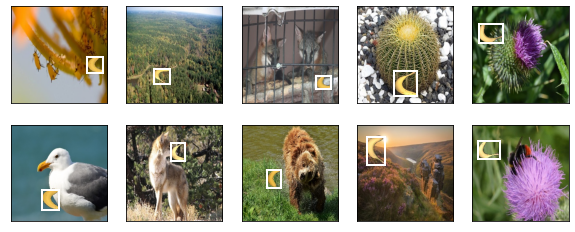

In [4]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Resumo

* O conjunto de dados de detecção de banana que sintetizamos pode ser usado para testar modelos de detecção de objetos.
* A leitura de dados para detecção de objetos é semelhante àquela para classificação de imagens. No entanto, depois de introduzirmos as caixas delimitadoras, a forma do rótulo e o aumento da imagem (por exemplo, corte aleatório) são alterados.


## Exercícios

1. Referindo-se à documentação do MXNet, quais são os parâmetros para os construtores das classes `image.ImageDetIter` e `image.CreateDetAugmenter`? Qual é o seu significado?


[Discussões](https://discuss.d2l.ai/t/1608)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE2NjQyMTYwNDQsMTAxOTQyMzc4Nyw1Mj
Q5OTMzNDUsLTg2OTEzMjEyOV19
-->
